In [1]:
cd /rdma/vast-rdma/vast/fiete/leokoz8/code/add_RL

/rdma/vast-rdma/vast/fiete/leokoz8/code/add_RL


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src import utils

%load_ext autoreload
%autoreload 2

In [94]:
def update_Q_function(Q,s,s_prime,a_prime,a,r):
    gamma = 0.95
    alpha = 0.8
    
    delta = r + gamma*np.max(Q[s_prime,:]) - Q[s,a]
    Q[s,a] += alpha*delta
    
    return Q

In [160]:
import gymnasium as gym
env = gym.make("FrozenLake-v1",render_mode = "rgb_array",map_name="8x8")
action_size = env.action_space.n
state_size = env.observation_space.n

T = int(199)
total_episodes = 400000
#to animate
frames = []


#epsilon greedy
max_epsilon = 1
min_epsilon = 0.01
decay_rate = 1e-7 

gamma = 0.95
learning_rate = 0.8


#initialize Q function
Q = np.zeros((state_size,action_size))

# List of rewards
rewards = []

# 2 For life or until learning is stopped
for episode in range(total_episodes):
    
    # Reset the environment
    s, info = env.reset(seed=42)
    step = 0
    total_rewards = 0
    
    
    # Reduce epsilon (because we need less and less exploration)    
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 


    for t in range(T):

        if np.random.uniform(0,1) > epsilon:
            a = np.argmax(Q[s,:])            
        else:
            a = env.action_space.sample()
            

        s_prime, r, terminated, truncated, info = env.step(a)

        Q[s, a] = Q[s, a] + learning_rate * (r + gamma * np.max(Q[s_prime, :]) - Q[s, a])

        s = s_prime

        total_rewards += r


        #uncomment to store frames for animation
        #frames.append(env.render())


        if terminated or truncated:
            break          
        
    
    rewards.append(total_rewards)
env.close()

print ("Score over time: " +  str(sum(rewards)/total_episodes))

Score over time: 0.00189


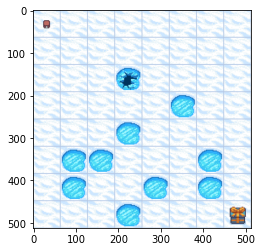

In [165]:
plt.imshow(env.render())

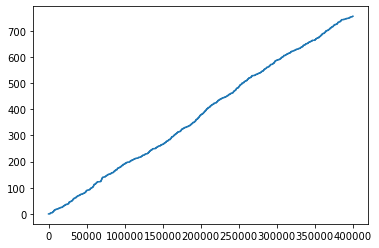

In [167]:
plt.plot(np.cumsum(rewards))

Remaining number of frames : 70
Remaining number of frames : 70
Remaining number of frames : 69
Remaining number of frames : 68
Remaining number of frames : 67
Remaining number of frames : 66
Remaining number of frames : 65
Remaining number of frames : 64
Remaining number of frames : 63
Remaining number of frames : 62
Remaining number of frames : 61
Remaining number of frames : 60
Remaining number of frames : 59
Remaining number of frames : 58
Remaining number of frames : 57
Remaining number of frames : 56
Remaining number of frames : 55
Remaining number of frames : 54
Remaining number of frames : 53
Remaining number of frames : 52
Remaining number of frames : 51
Remaining number of frames : 50
Remaining number of frames : 49
Remaining number of frames : 48
Remaining number of frames : 47
Remaining number of frames : 46
Remaining number of frames : 45
Remaining number of frames : 44
Remaining number of frames : 43
Remaining number of frames : 42
Remaining number of frames : 41
Remainin

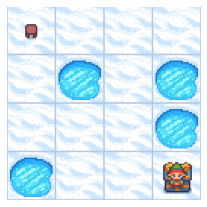

In [140]:
env.reset()
frames = []

for episode in range(10):
    
    s,info = env.reset(seed=42)

    for step in range(T):
        
        # Take the action (index) that have the maximum expected future reward given that state
        a = np.argmax(Q[s,:])
        
        s_prime, r, terminated, truncated, info = env.step(a)
        frames.append(env.render())
        if terminated or truncated:
            break
        s = s_prime
env.close()

utils.save_frames_as_gif(frames)